# Spettro del Rubino

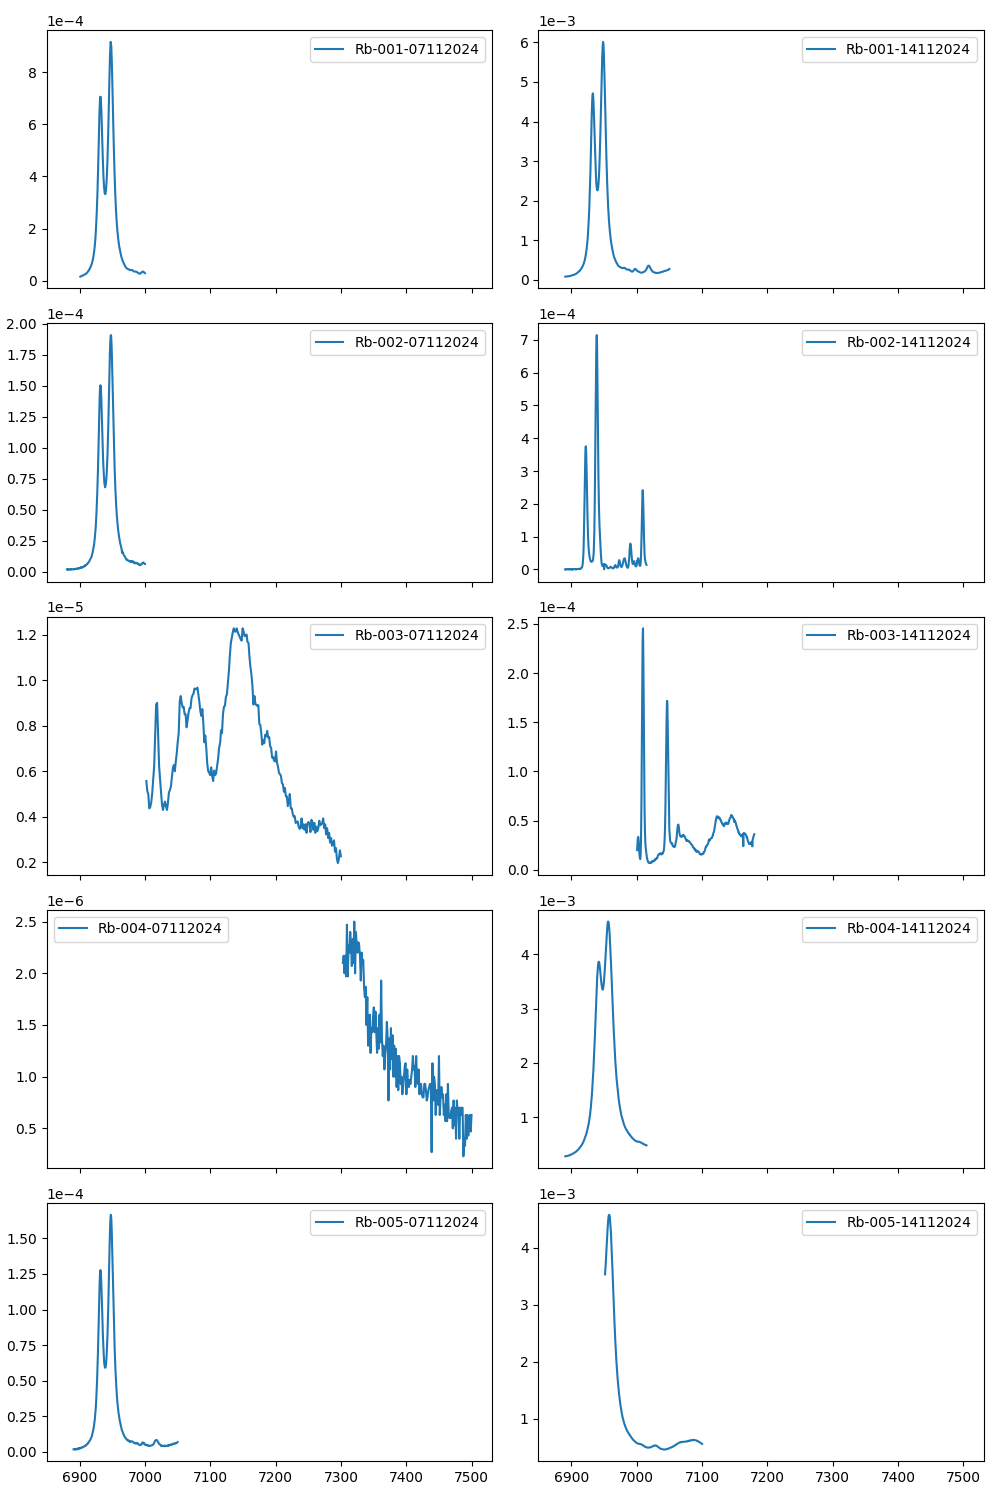

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from modules import utils
import pandas as pd
import ast
import scipy as sp
from matplotlib import cm
%matplotlib widget

plt.close('all')

# Load data
files = utils.getFiles('Raw_Data\\Rubidium_Spectrum')
files = [file for file in files if file.name.find('Rb_') != -1]
df = pd.DataFrame([utils.file_to_series(file) for file in files])

# sort it
df.sort_values('id', inplace=True)
df.sort_values('date', inplace=True)
df.reset_index(drop=True, inplace=True)

# A quick look at the data
fig, axs = plt.subplots(5, 2, sharex=True, figsize=(10, 15), layout='tight')
for i, row in df.iterrows():
    meta = ast.literal_eval(row['meta'])
    label = "-".join([meta.get(key) for key in ['type', 'id', 'date',]])
    axs[ i % 5, int(i / 5)].plot(row['wl'], row['mean'], label=label)
    
for ax in axs.flat:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) 
    ax.legend()

In [ ]:
from ipywidgets import FloatRangeSlider, FloatLogSlider, AppLayout, interactive, VBox, Output
# 07-11-2024
batch = df[df['date'] == '07112024']

# generate the info table
info = batch['meta'].apply(ast.literal_eval).apply(pd.Series)
info = info[['type', 'id', 'date'] + [col for col in info.columns if col not in ['type', 'id', 'date']]]
info['start'] = batch['wl'].apply(lambda x: x[0])
info['stop'] = batch['wl'].apply(lambda x: x[-1])
info['step'] = batch['wl'].apply(lambda x: x[1] - x[0])


cm = plt.get_cmap('tab10')
with plt.ioff():
    fig, ax = plt.subplots(figsize=(8, 5))    
    

def find_peaks(prominence=6e-7, width=(1, 20)):
    '''This function will be turned into a widget'''
    ax.clear()
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    ax.set_yscale('log')
    
    
    for i, row in batch.iterrows():
        label = " ".join([row['type'], row['id']])
        ax.plot(row['wl'], row['mean'], label=label, color=cm(i))
        peaks, properties = sp.signal.find_peaks(row['mean'], prominence=prominence, width=width)
        
        # find the peaks
        if len(peaks) == 0:
            continue
        
        ax.plot(row['wl'][peaks], row['mean'][peaks], "x", color=cm(i))
        res_full = sp.signal.peak_widths(row['mean'], peaks, rel_height=.5)
     
        # HACK: for some reason res_full[1:] is treathed as a tuple
        y, xmin, xmax = res_full[1:]
        xmin = info.loc[i, 'start'] + info.loc[i, 'step'] * xmin
        xmax = info.loc[i, 'start'] + info.loc[i, 'step'] * xmax
        
        ax.vlines(x=row['wl'][peaks], ymin=row['mean'][peaks] - properties["prominences"],
                    ymax = row['mean'][peaks], color = cm(i), alpha=0.5)  
        ax.hlines(y=y, xmin=xmin, xmax=xmax, color=cm(i), alpha=0.5)
    
    ax.legend()
    return

prominance = FloatLogSlider(value=1.22e-6, base=10, min=-8, max=-2, step=0.01, readout_format='.3e')
width = FloatRangeSlider(value=(1, 20), min=0, max=40, step=1, readout_format='d')
w = interactive(find_peaks, prominence=prominance, width=width)
out = Output()
with out:
    display(info)

AppLayout(
    center=fig.canvas,
    right_sidebar=w,
    footer = out,
    pane_widths=[0, 2, 1]
)

AppLayout(children=(Output(layout=Layout(grid_area='footer')), interactive(children=(FloatLogSlider(value=1.22…